In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
from slime import lime_tabular

import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
sys.path.append(join(dir_path, "HelperFiles"))
import helper
import load_data
import train_models
import top_k

import warnings
warnings.filterwarnings('ignore')

data_path = join(dir_path, "Experiments", "Data")
K = 5
alpha = 0.1

## Load Shapley Sampling & StableSHAP results on Census

In [2]:
import pickle

results_path = join(dir_path, "Experiments", "Results", "Top_K", "rank", "alpha_0.1")
with open(join(results_path, "stableshap_vs_ss_k5"), "rb") as fp:
    results5_alpha01 = pickle.load(fp)
stableshap_fwers5_alpha01 = np.array([helper.calc_fwer(top_Ks_pt) for top_Ks_pt in results5_alpha01['rankshap']])
ss_adaptive_fwers5_alpha01 = np.array([helper.calc_fwer(top_Ks_pt) for top_Ks_pt in results5_alpha01['ss_adaptive']])

idx_of_hardest_for_ss = np.argmax(ss_adaptive_fwers5_alpha01)
x_idx = results5_alpha01['x_indices'][idx_of_hardest_for_ss]
print(x_idx)
print(stableshap_fwers5_alpha01[idx_of_hardest_for_ss])
print(np.max(ss_adaptive_fwers5_alpha01))

# Get top-K rankings for that point
stableshap_top_K = np.array(results5_alpha01['rankshap'][idx_of_hardest_for_ss])
ss_top_K = np.array(results5_alpha01['ss_adaptive'][idx_of_hardest_for_ss])

16
0.08
0.24


## Load Census Data

In [3]:
dataset = "census"
X_train, y_train, X_test, y_test, mapping_dict = load_data.load_data(data_path, dataset)
d = X_train.shape[1]
print(len(y_test), np.mean(y_test))
model = train_models.train_neural_net(X_train, y_train)

y_preds = (model(X_test) > 0.5).astype("int")
print("{}% accuracy".format(round(np.mean(y_preds == y_test)*100)))

N_runs = 25
xloc = X_test[x_idx]

8140 0.25196560196560197
82% accuracy


Commented-out code generates the loaded results

In [4]:
# import importlib
# np.random.seed(1)

# sprtshap_vals_all = []
# while len(sprtshap_vals_all) < N_runs:
#     sprtshap_vals, _, N, converged = top_k.sprtshap(model, X_train, xloc, mapping_dict=mapping_dict, K=K, alpha=alpha, 
#                                                     guarantee="rank", n_samples_per_perm=10, n_perms_btwn_tests=1000, 
#                                                     n_max=50000, beta=0.2, abs=True)
#     sprtshap_vals_all.append(sprtshap_vals)
# np.save(join(results_path, "census_xidx_{}_sprtshap_vals".format(x_idx)), sprtshap_vals_all)


In [5]:
sprtshap_vals_all = np.load(join(results_path, "census_xidx_{}_sprtshap_vals.npy".format(x_idx)), allow_pickle=True)

In [6]:
order_sprt = [helper.get_ranking(shap_values, abs=True) for shap_values in sprtshap_vals_all]
sprt_top_K = np.array(order_sprt)[:,:K]
print(helper.calc_fwer(sprt_top_K))

def calc_freqs(top_Ks):
    freqs = []
    for k in range(K):
        kth_ranks = top_Ks[:,k]
        freqs.append(np.mean(kth_ranks==mode(kth_ranks)[0]).item())
    return freqs

freqs_sprt = calc_freqs(sprt_top_K)
print(freqs_sprt)
freqs_ss = calc_freqs(ss_top_K)
print(freqs_ss)
freqs_stableshap = calc_freqs(stableshap_top_K)
print(freqs_stableshap)

0.04
[1.0, 1.0, 1.0, 0.96, 0.96]
[1.0, 1.0, 1.0, 0.76, 0.76]
[1.0, 1.0, 1.0, 0.92, 0.92]


## LIME

In [7]:
model = train_models.train_model(X_train, y_train, "nn", lime=True)

In [8]:
# lime_top_K = []
# explainer = lime_tabular.LimeTabularExplainer(X_train, 
#                                               discretize_continuous = False, 
#                                               feature_selection = "lasso_path", 
#                                               sample_around_instance = True)
# for _ in range(N_runs):
#     exp = explainer.explain_instance(xloc, model, num_features = K, num_samples = 50000) # Default
#     tuples = exp.local_exp[1]
#     feats = [tuples[i][0] for i in range(5)]
#     lime_top_K.append(feats)
# print(helper.calc_fwer(lime_top_K))
# np.save(join(results_path, "census_xidx_{}_lime_top_K".format(x_idx)), lime_top_K)


In [9]:
lime_top_K = np.load(join(results_path, "census_xidx_{}_lime_top_K.npy".format(x_idx)), allow_pickle=True)

### SLIME

In [10]:
# np.random.seed(1)
# slime_top_K = []
# while len(slime_top_K) < N_runs:
#     exp, converged = explainer.slime(xloc, model, num_features = K, 
#                                 num_samples = 1000, n_max = 200000,
#                                 alpha = alpha/K/2, tol=0)
#     # if converged:
#     tuples = exp.local_exp[1]
#     feats = [tuples[i][0] for i in range(K)]
#     slime_top_K.append(feats)
#     # print(len(slime_top_K))
# print(helper.calc_fwer(slime_top_K))
# np.save(join(results_path, "census_xidx_{}_slime_top_K".format(x_idx)), slime_top_K)


In [11]:
slime_top_K = np.load(join(results_path, "census_xidx_{}_slime_top_K.npy".format(x_idx)), allow_pickle=True)

In [12]:
lime_top_K, slime_top_K = np.array(lime_top_K), np.array(slime_top_K)
freqs_lime = calc_freqs(lime_top_K)
print(freqs_lime)
freqs_slime = calc_freqs(slime_top_K)
print(freqs_slime)

[1.0, 1.0, 1.0, 0.68, 0.64]
[1.0, 1.0, 1.0, 1.0, 1.0]


## Visualize

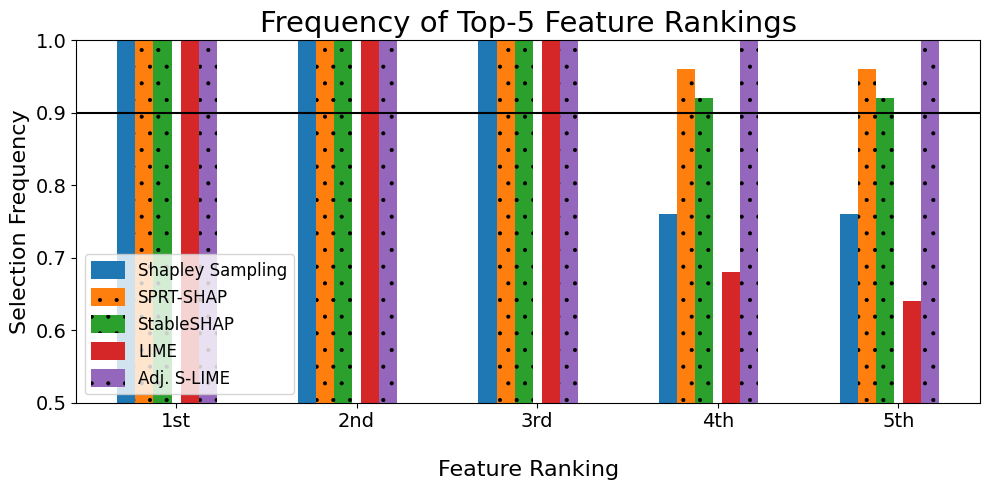

In [13]:
plt.figure(figsize=(10,5))
width = 0.1

# Plotting
import matplotlib as mpl
mpl.rcParams['hatch.color'] = 'black'
mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

onetoK = np.arange(K)+1
plt.bar(onetoK-.225, freqs_ss, width, label='Shapley Sampling')
plt.bar(onetoK-.125, freqs_sprt , width, label='SPRT-SHAP', hatch=".")
plt.bar(onetoK-.025, freqs_stableshap , width, label='StableSHAP', hatch=".")

plt.bar(onetoK+.125, freqs_lime, width, label='LIME')
plt.bar(onetoK+.225, freqs_slime , width, label='Adj. S-LIME', hatch=".")

plt.xlabel('\nFeature Ranking', size=16)
plt.ylabel('Selection Frequency', size=16)
plt.title('Frequency of Top-5 Feature Rankings', size=21)

order = ["1st", "2nd", "3rd", "4th", "5th"]
plt.xticks(onetoK + width / 2, order)
plt.axhline(0.9, color="black")
plt.ylim(.5,1)
plt.tick_params(labelsize=14)
# Finding the best position for legends and putting it
plt.legend(loc='lower left', prop={'size': 12}, handleheight=1.3, fontsize=16)
plt.tight_layout()
plt.savefig(join(dir_path, "Experiments", "Figures", "instability.pdf"), bbox_inches="tight", format='pdf', dpi=300)
plt.show()